<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
import os
import copy
import pickle
import typing
import itertools
import functools
import heapq
import operator
import collections
from glob import glob, iglob

import numpy as np
import pandas as pd
import seaborn as sns
import scipy

from tqdm import tqdm_notebook
from scipy.sparse import csr_matrix
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from matplotlib import pyplot as plt

%matplotlib inline
pd.set_option('display.max.columns', 25)

In [2]:
PATH_TO_DATA = 'Data/Raw/'
PATH_TO_PICKLED = 'Data/Pickled/'
PATH_TO_MERGED = 'Data/Merged/'
PATH_TO_ANSWERS = 'Answers/'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
class __RollingWindowIterator:
    def __init__(self, iterable: typing.Iterable, window_size: int, rolling_step: int) -> type(None):
        if not 1 <= rolling_step <= window_size:
            raise IndexError("'rolling_step' should not be greater than 'size' or lower that 1")

        self.it = iter(iterable)
        self.rolling_step = rolling_step
        self.window_size = window_size

        self.buffered_it = None
        self.i = 0

    def __next__(self) -> typing.Iterator:
        if self.i == self.rolling_step:
            self.buffered_it = copy.copy(self.it)
        if self.i != self.window_size:
            self.i += 1
        else:
            self.i = 1
            self.it = self.buffered_it
        return next(self.it)

    def __iter__(self) -> '__RollingWindowIterator':
        return self


def split_to_equally_sized(sequence: typing.Sequence,
                           size: int,
                           rolling_step: typing.Optional[int] = None,
                           padvalue: typing.Any = None) -> typing.Iterable[typing.Sequence]:
    """
    Splits an iterable type to equally sized tuples, and if the last chunk appears to be incomplete,
    pads it with the value specified.

    Examples:
    1)  list(split_to_equally_sized(['a', 'b', 'c', 'd', 'e', 'f', 'g'], 3, padvalue='padval'))
        >>> [('a', None, 42443), (-1, 'e', 'f'), ('g', 'padval', 'padval')]
    2)  list(split_to_equally_sized(['a', None, 42443, -1, 'e', 'f', 'g'], 4, 2, 'padval'))
        >>> [('a', None, 42443, -1),
             (42443, -1, 'e', 'f'),
             ('e', 'f', 'g', 'padval'),
             ('g', 'padval', 'padval', 'padval')]

    Args:
        iterable:      any iterable you want to split
        size:          chunk size
        rolling_step:  chunk start shift step. Should be >= 1 and <= 'size'. See the second example for clarity.

                       If not specified, the chunks do not intersect,
                       and the behavior is equal to the case where 'rolling_step' equals to 'size'.

                       --- Attention! ---
                       Specifying this parameter greatly slows down the function.
                       For example:
                       1)  list(split_to_equally_sized(iterable, size, padvalue=padvalue))
                       2)  list(split_to_equally_sized(iterable, size, size - 1, padvalue=padvalue))
                       Although the result is nearly the same, the second option is about 100 times slower.

        padvalue:      padding value to fill incomplete chunks
                       (that exist if the total number of iterations of 'iterable' is not divisible by 'size')
    Returns:
        itertools.zip_longest generator (that can later be calculated on the fly)
    """

    if isinstance(sequence, (pd.Series, pd.DataFrame)):
        sequence = sequence.values
    iterator = (iter(sequence) if not rolling_step or rolling_step == size
                else __RollingWindowIterator(sequence, size, rolling_step))

    return itertools.zip_longest(*((iterator,) * size), fillvalue=padvalue)

In [4]:
def __read_user_csv(file_name_and_user_ID: typing.Tuple[str, int]) -> pd.DataFrame:
    file_name, user_id = file_name_and_user_ID
    df = pd.read_csv(file_name, infer_datetime_format=True, parse_dates=['timestamp'])
    df['diffs'] = df['timestamp'].diff().fillna(pd.Timedelta(0)).dt.total_seconds().astype(int)
    df.index = np.repeat(user_id, df.shape[0])
    return df


__user_info_dict = typing.Mapping[str, typing.Tuple[int, int]]


def prepare_train_set(path_to_csv_files: str,
                      session_length: int = 10) -> typing.Tuple[pd.DataFrame, __user_info_dict]:

    user_csvs_and_IDs = sorted(
        map(lambda x: (x, int(x.split('/')[-1][4:-4])), iglob(os.path.join(path_to_csv_files, '*.csv'))),
        key=lambda x: x[1]
    )

    user_history = pd.concat(map(__read_user_csv, user_csvs_and_IDs))

    __site_counts = user_history['site'].value_counts()
    __site_IDs = pd.Series(
        index=__site_counts.index,
        data=range(1, len(__site_counts) + 1)
    )

    user_history = pd.Series(
        index=user_history.index,
        data=__site_IDs[user_history['site']].values
    )
    session_histories = tuple(
        (*session, user_ID)
        for user_ID, cur_user_history in user_history.groupby(user_history.index)
        for session in split_to_equally_sized(
            cur_user_history,
            session_length,
            padvalue=0
        )
    )
    session_histories = pd.DataFrame(
        data=session_histories,
        columns=['site' + str(i) for i in range(1, session_length + 1)] + ['user_id']
    )
    session_histories.index.name = 'session_id'

    site_stats = dict(zip(__site_counts.index, zip(__site_IDs.values, __site_counts.values)))

    return session_histories, site_stats


def construct_csr_matrix(session_matrix: typing.Iterable[typing.Iterable[int]]) -> scipy.sparse.csr.csr_matrix:
    site_counts, session_IDs, site_IDs = zip(
        *(
            (site_count, session_ID, site_ID - 1)
            for session_ID, site_counts_for_session in enumerate(map(collections.Counter, session_matrix))
            for site_ID, site_count in site_counts_for_session.items()
            if site_ID != 0
        )
    )
    return csr_matrix((site_counts, (session_IDs, site_IDs)))


def __find_unique_site_IDs_count(array: typing.Sequence[int]) -> int:
    __set = set(array)
    __set.discard(0)
    return len(__set)


def prepare_train_set_with_fe(path_to_csv_files: str,
                              site_freq_path: str,
                              feature_names: typing.Sequence[str],
                              session_length: int = 10,
                              window_size: int = 10) -> pd.DataFrame:
    with open(site_freq_path, 'rb') as dump_file:
        site_name_to_ID_and_freq = pickle.load(dump_file)

    site_name_to_ID = pd.Series(
        index=site_name_to_ID_and_freq.keys(),
        data=next(zip(*site_name_to_ID_and_freq.values()))
    )

    __user_csvs_and_IDs = sorted(
        map(lambda x: (x, int(x.split('/')[-1][4:-4])), iglob(os.path.join(path_to_csv_files, '*.csv'))),
        key=lambda x: x[1]
    )
    user_history = pd.concat(map(__read_user_csv, __user_csvs_and_IDs))
    user_history['site'] = pd.Series(
        index=user_history.index,
        data=site_name_to_ID[user_history['site']].values
    )

    user_ID_for_session = []
    def callback(session: typing.Sequence[int], user_ID: int) -> typing.Sequence[int]:
        """
        Returns the history sequence for the current session,
        storing the corresponding user_ID in the 'user_ID_for_session'
        """
        user_ID_for_session.append(user_ID)
        return session

    session_histories = np.array(
        tuple(
            callback(session, user_ID)
            for user_ID, cur_user_history in user_history.groupby(user_history.index)
            for session in split_to_equally_sized(
                cur_user_history,
                session_length,
                window_size,
                padvalue=(pd.NaT, 0, 0)
            )
        )
    )
    starting_timestamps = tuple(session_histories[:,0,0])
    site_ID_matrix = session_histories[:,:,1].astype(int)
    timediffs_matrix = session_histories[:,1:,2].astype(int)

    total_timediff = timediffs_matrix.sum(1)
    unique_sites = np.fromiter(map(__find_unique_site_IDs_count, site_ID_matrix), dtype=np.int)
    start_hours, days_of_week = zip(*map(lambda x: (x.hour, x.weekday()), starting_timestamps))

    user_ID_for_session = user_ID_for_session

    data = (*site_ID_matrix.T, *timediffs_matrix.T, total_timediff, unique_sites,
            start_hours, days_of_week, user_ID_for_session, starting_timestamps)
    data = dict(zip(feature_names + ['start_time'], data))
    return pd.DataFrame(data)

**Проверим функцию на игрушечном примере.**

In [5]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

In [6]:
%%time
train_data_toy = prepare_train_set_with_fe(
    os.path.join(PATH_TO_DATA, '3users'),
    site_freq_path=os.path.join(PATH_TO_PICKLED, 'site_freq_3users.pkl'),
    feature_names=feature_names,
    session_length=10
)

CPU times: user 17.6 ms, sys: 1.76 ms, total: 19.3 ms
Wall time: 19.6 ms


In [7]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target,start_time
0,4,2,2,11,2,1,10,6,9,7,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1,2013-11-15 09:28:17
1,4,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1,2013-11-15 12:40:35
2,4,2,5,5,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2,2013-11-15 09:28:17
3,3,1,2,1,2,1,1,6,8,3,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3,2013-11-15 09:28:17
4,3,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3,2013-11-15 12:28:17


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_10users = prepare_train_set_with_fe(
    os.path.join(PATH_TO_DATA, '10users'),
    os.path.join(PATH_TO_PICKLED, 'site_freq_10users.pkl'),
    feature_names=feature_names,
    session_length=10
)

CPU times: user 1.23 s, sys: 48.3 ms, total: 1.28 s
Wall time: 1.28 s


In [9]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target,start_time
0,193,576,134,3,134,134,3,134,203,134,10,0,0,1,20,1,0,1,0,33,5,8,4,31,2013-11-15 08:12:07
1,415,192,697,254,134,31,393,4575,218,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31,2013-11-15 08:12:40
2,55,3,55,55,5,294,415,333,917,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31,2013-11-15 08:17:25
3,482,3568,482,55,55,55,55,1005,201,124,2,1,0,1,25,1,0,0,0,30,6,8,4,31,2013-11-15 08:21:43
4,346,55,5,4382,261,212,3727,2450,675,2450,1,0,1,1,1,0,1,1,0,6,9,8,4,31,2013-11-15 08:22:13


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [10]:
%%time
train_data_150users = prepare_train_set_with_fe(
    os.path.join(PATH_TO_DATA, '150users'),
    site_freq_path=os.path.join(PATH_TO_PICKLED, 'site_freq_150users.pkl'),
    feature_names=feature_names,
    session_length=10
)

CPU times: user 13min 4s, sys: 4.55 s, total: 13min 9s
Wall time: 13min 9s


In [11]:
train_data_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target,start_time
0,1,1,4,2,1,4,1,2,1294,321,1,1,1,4,0,1,0,49,0,57,5,8,4,6,2013-11-15 08:01:09
1,2,23,1512,1294,321,321,113,73,49,49,0,0,26,1,10,73,0,1504,4,1618,8,8,4,6,2013-11-15 08:02:06
2,321,205,1,1,1,1,73,321,2,1,1,10,1,5,16,56,1917,0,4,2010,5,8,4,6,2013-11-15 08:29:06
3,1,1,7252,7252,5702,7252,7252,1,35,1,1,0,1,0,118,420,1460,6,0,2006,4,9,4,6,2013-11-15 09:02:53
4,1,1,76,1,58,50,58,50,83,76,4,3,0,1,0,1,0,1,0,10,5,9,4,6,2013-11-15 09:36:22


In [12]:
new_features = train_data_10users.columns[10:]

**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [13]:
train_data_10users[new_features].to_pickle(
    os.path.join(PATH_TO_PICKLED, 'new_features_10users.pkl')
)
train_data_150users[new_features].to_pickle(
    os.path.join(PATH_TO_PICKLED, 'new_features_150users.pkl')
)
train_data_10users.to_pickle(os.path.join(PATH_TO_PICKLED, '10users.pkl'))
train_data_150users.to_pickle(os.path.join(PATH_TO_PICKLED, '150users.pkl'))

In [6]:
train_data_10users = pd.read_pickle(os.path.join(PATH_TO_PICKLED, '10users.pkl'))
train_data_150users = pd.read_pickle(os.path.join(PATH_TO_PICKLED, '150users.pkl'))

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [15]:
median = str(int(train_data_10users['session_timespan'].median()))
with open(os.path.join(PATH_TO_ANSWERS, 'week3_1.txt'), 'w') as out:
    out.write(median)
f'Медианная продолжительность сессии: {median}'

'Медианная продолжительность сессии: 37'

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [16]:
median = str(int(train_data_10users['day_of_week'].median()))
with open(os.path.join(PATH_TO_ANSWERS, 'week3_2.txt'), 'w') as out:
    out.write(median)
f'Медианный день начала сессии: {median}'

'Медианный день начала сессии: 2'

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [17]:
median = str(int(train_data_150users['start_hour'].median()))
with open(os.path.join(PATH_TO_ANSWERS, 'week3_3.txt'), 'w') as out:
    out.write(median)
f'Медианный час начала сессии: {median}'

'Медианный час начала сессии: 13'

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [18]:
median = str(int(train_data_150users['#unique_sites'].median()))
with open(os.path.join(PATH_TO_ANSWERS, 'week3_4.txt'), 'w') as out:
    out.write(median)
f'Медианное значение числа уникальных сайтов: {median}'

'Медианное значение числа уникальных сайтов: 7'

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [7]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
                33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = pd.Categorical(train_data_10users['target'].map(id_name_dict))

In [8]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey': 'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

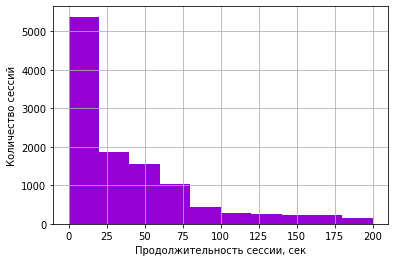

In [21]:
train_data_10users['session_timespan'].hist(color='darkviolet', range=(0, 200))
plt.xlabel('Продолжительность сессии, сек')
plt.ylabel('Количество сессий')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

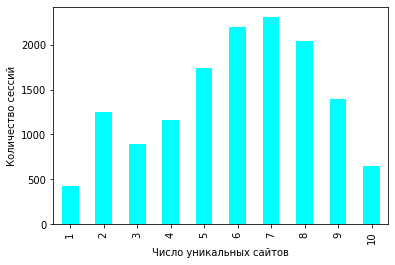

In [22]:
train_data_10users['#unique_sites'].value_counts().sort_index().plot(kind='bar', color='aqua')
plt.xlabel('Число уникальных сайтов')
plt.ylabel('Количество сессий')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

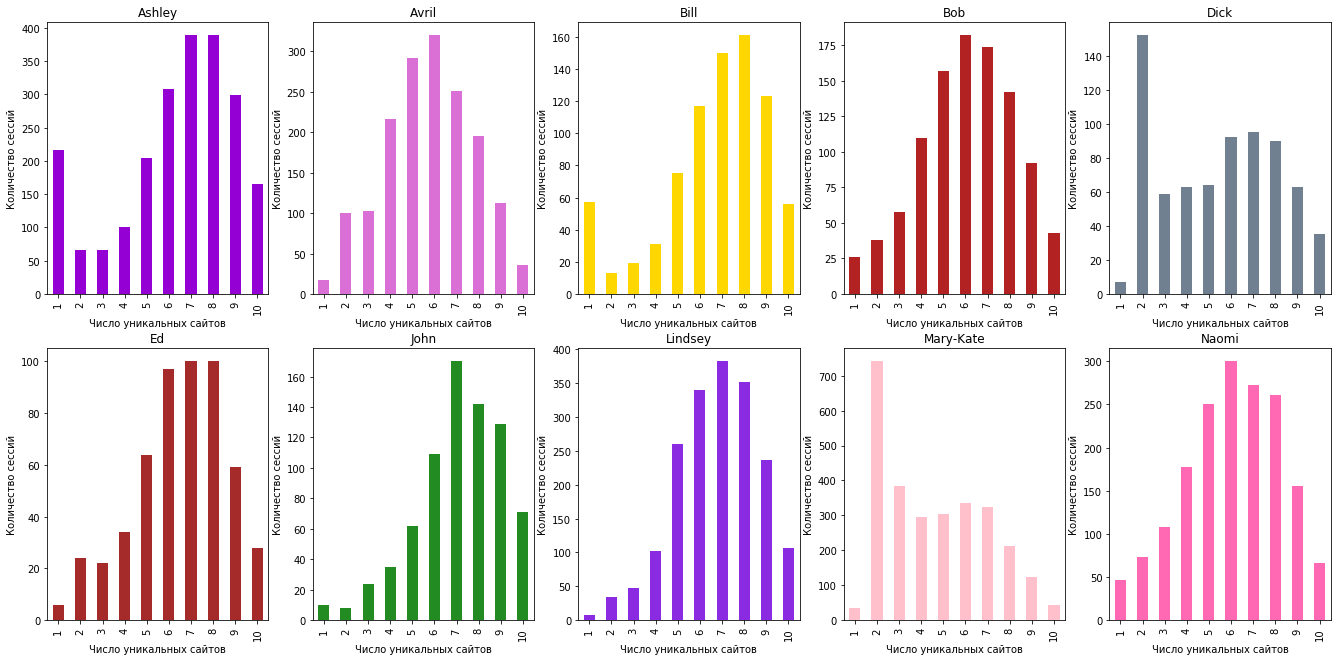

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(23, 11))

for idx, ((user, sub_df), ax) in enumerate(zip(train_data_10users.groupby('target')['#unique_sites'],
                                               axes.flatten())):
    sub_df.value_counts().sort_index().plot(kind='bar', ax=ax, color=color_dic[user])
    ax.set_title(user)
    ax.set_ylabel('Количество сессий')
    ax.set_xlabel('Число уникальных сайтов')

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

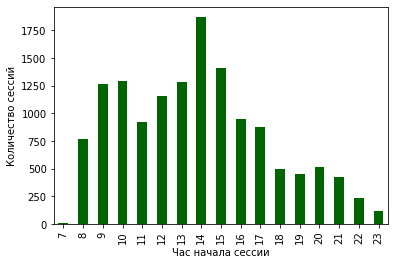

In [24]:
train_data_10users['start_hour'].value_counts().sort_index().plot(kind='bar', color='darkgreen')
plt.xlabel('Час начала сессии')
plt.ylabel('Количество сессий')
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

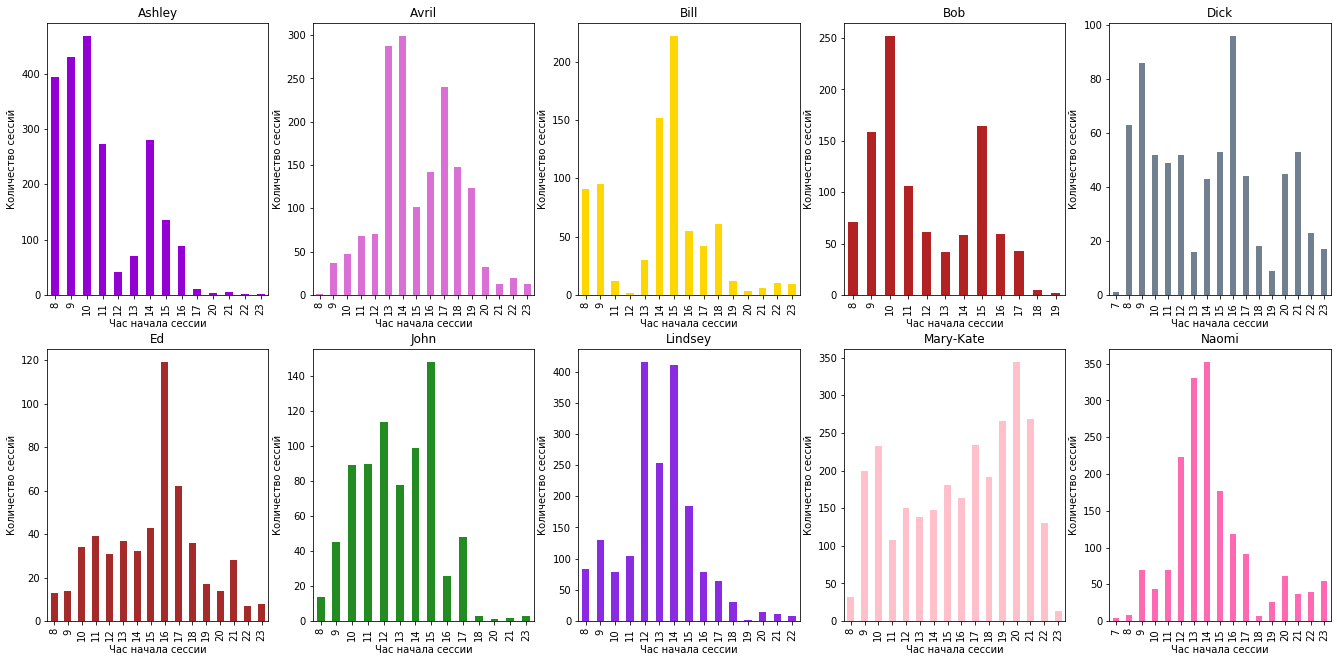

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(23, 11))

for idx, ((user, sub_df), ax) in enumerate(zip(train_data_10users.groupby('target')['start_hour'],
                                               axes.flatten())):
    sub_df.value_counts().sort_index().plot(kind='bar', ax=ax, color=color_dic[user])
    ax.set_title(user)
    ax.set_ylabel('Количество сессий')
    ax.set_xlabel('Час начала сессии')

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

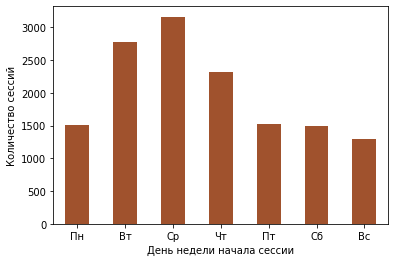

In [11]:
fig = plt.figure()
ax = fig.add_subplot()

train_data_10users['day_of_week'].value_counts().sort_index().plot(kind='bar', color='sienna')
weekdays = np.array(('Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'))

ax.set_xticklabels(weekdays, rotation=0)
plt.xlabel('День недели начала сессии')
plt.ylabel('Количество сессий')
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

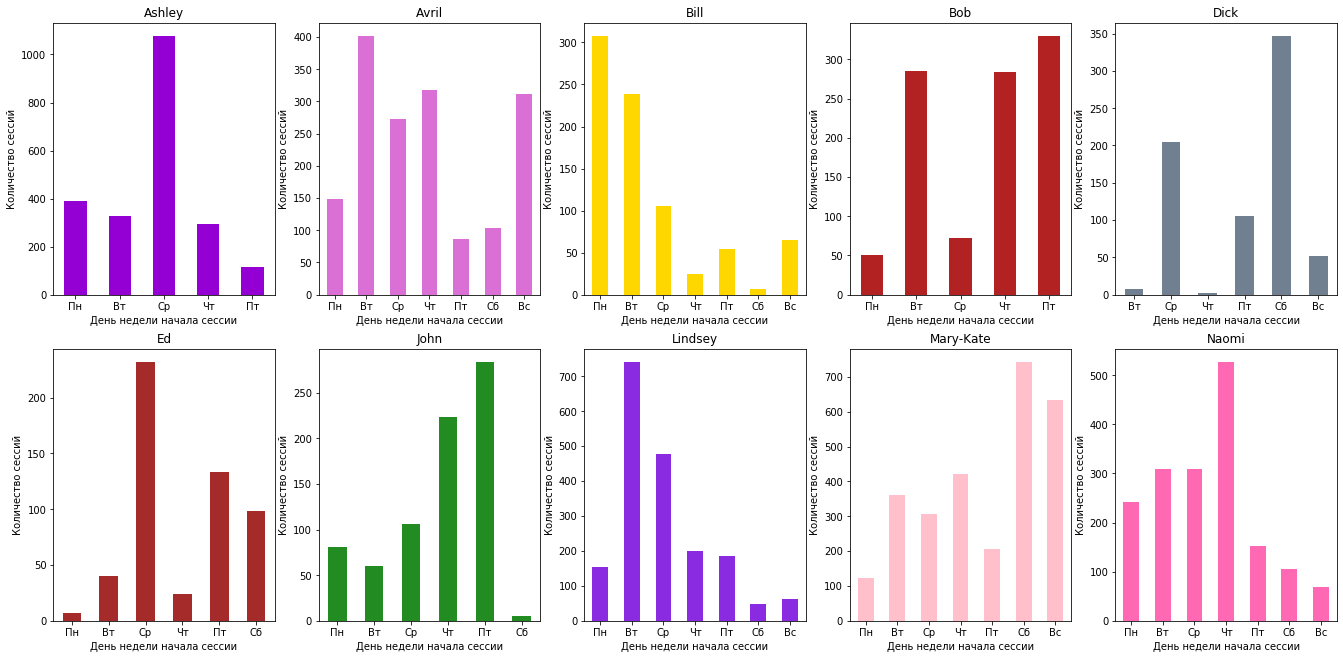

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(23, 11))

for idx, ((user, sub_df), ax) in enumerate(zip(train_data_10users.groupby('target')['day_of_week'],
                                               axes.flatten())):
    sub_df.value_counts().sort_index().plot(kind='bar', ax=ax, color=color_dic[user])
    ax.set_title(user)
    ax.set_ylabel('Количество сессий')
    ax.set_xlabel('День недели начала сессии')
    ax.set_xticklabels(weekdays[sub_df.min():(sub_df.max() + 1)], rotation=0)

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Видим, что каждый пользователь может быть характеризован своим уникальным распределениями часа и дня начала сессии.

Например, Эд, Линдси и Эшли больше других предпочитают определённый день недели в то время, как для Аврила и Наоми характерно более равномерное распределение по дням недели.

Также практически все пользователи, за исключением Мэри-Кейт, предпочитают определённую часть суток.

- Эшли
 - Характерный день недели: Ср
 - Характерное время начала сессии: Утро после 8 и днём в 14-15
- Аврил
 - Характерный день недели: Больше во Вт, меньше - в Пт и Сб
 - Характерное время начала сессии: Днём в 13 и 17
- Билл
 - Характерный день недели: Пн
 - Характерное время начала сессии: Днём в 14-15 и утром после в 8-9
- Боб
 - Характерный день недели: Вт, Чт, Пт, выходные отсутствуют
 - Характерное время начала сессии: 10 и 15
- Дик
 - Характерный день недели: Ср, Сб; Пт отсутствует
 - Характерное время начала сессии: 8-9, 16 и 21
- Эд
 - Характерный день недели: Ср
 - Характерное время начала сессии: 16
- Джон
 - Характерный день недели: Чт, Пт
 - Характерное время начала сессии: Более-менее равномерно с пиком в 15, почти не заходит после 18
- Линдси
 - Характерный день недели: Вт, Ср
 - Характерное время начала сессии: 12, 14
- Мэри-Кейт
 - Характерный день недели: Сб, Вс
 - Характерное время начала сессии: Более-менее равномерно с пиком в 20
- Наоми
 - Характерный день недели: Чт, меньше в выходные
 - Характерное время начала сессии: 13-14

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [28]:
with open(os.path.join(PATH_TO_PICKLED, 'site_freq_10users.pkl'), 'rb') as freq_file:
    site_freq_10users = heapq.nlargest(10, pickle.load(freq_file).items(), key=lambda x: x[1][1])

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [29]:
top10_sites = np.array(
    tuple(
        map(
            operator.itemgetter(0),
            heapq.nlargest(10, site_freq_10users, key=lambda x: x[1][1])
        )
    )
)
top10_freqs = np.array(
    heapq.nlargest(
        10,
        map(
            lambda x: x[1][1],
            site_freq_10users
        )
    )
)
print(top10_sites)
print(top10_freqs)

['s.youtube.com' 'www.google.fr' 'www.google.com' 'mail.google.com'
 'www.facebook.com' 'apis.google.com'
 'r3---sn-gxo5uxg-jqbe.googlevideo.com'
 'r1---sn-gxo5uxg-jqbe.googlevideo.com' 'plus.google.com'
 'accounts.google.com']
[8300 7813 5441 4158 4141 3758 3244 3094 2630 2089]


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

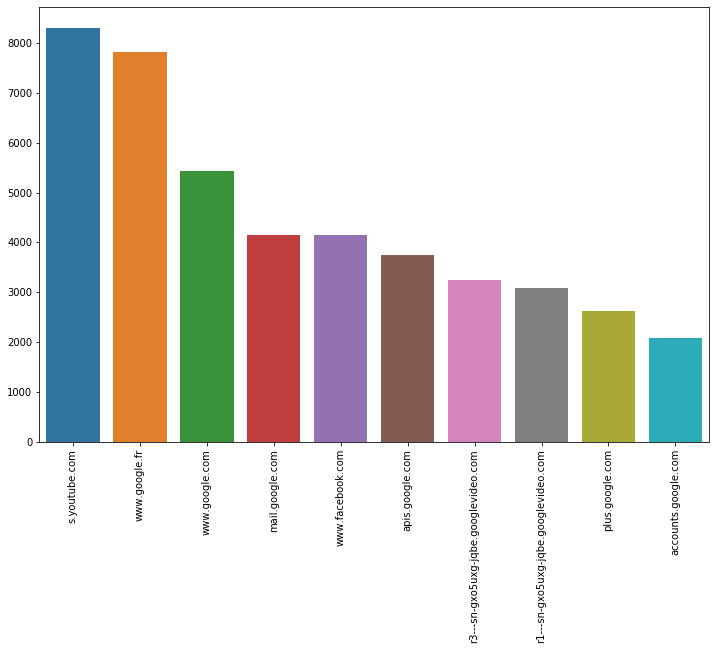

In [30]:
plt.figure(figsize=(12, 8))
plt.xticks(rotation='vertical')
sns.barplot(x=top10_sites, y=top10_freqs)
plt.show()

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [31]:
time_of_day = dict(
    itertools.chain(
        zip(range(3), itertools.repeat('night')),
        zip(range(3, 9), itertools.repeat('morning')),
        zip(range(9, 15), itertools.repeat('day')),
        zip(range(15, 21), itertools.repeat('evening')),
        zip(range(21, 24), itertools.repeat('night'))
    )
)

In [32]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    site_ID_cols = pd.Index(filter(lambda col: col[:4] == 'site', df.columns))
    time_diff_cols = pd.Index(filter(lambda col: col[:9] == 'time_diff', df.columns))
    site_IDs = df[site_ID_cols]
    time_diffs = df[time_diff_cols]

    session_length = site_IDs.shape[1]

    time_diff_std = df[time_diff_cols][
        pd.DataFrame(
            columns=time_diff_cols,
            index=df.index,
            data=(site_IDs.iloc[:,1:] != 0).values
        )
    ].std(1)
    times_of_day = pd.Categorical(
        df['start_hour'].apply(lambda x: time_of_day[x]),
        ordered=True,
        categories=['morning', 'day', 'evening', 'night']
    )
    num_consec_sites = ((site_IDs.diff(axis=1) == 0) & (site_IDs != 0)).sum(1)
    return pd.DataFrame(
        data={
            'num_consecutive_sites': num_consec_sites,
            'time_of_day': times_of_day,
            'time_diff_std': time_diff_std
        }
    )

In [33]:
new_features_10users = feature_engineering(train_data_10users)
new_10users = pd.concat((train_data_10users, new_features_10users), axis=1)
new_10users

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target,start_time,num_consecutive_sites,time_of_day,time_diff_std
0,193,576,134,3,134,134,3,134,203,134,10,0,...,0,1,0,33,5,8,4,John,2013-11-15 08:12:07,1,morning,6.910137
1,415,192,697,254,134,31,393,4575,218,55,1,0,...,3,3,8,284,10,8,4,John,2013-11-15 08:12:40,0,morning,59.912668
2,55,3,55,55,5,294,415,333,917,55,0,14,...,1,0,0,258,7,8,4,John,2013-11-15 08:17:25,1,morning,80.129583
3,482,3568,482,55,55,55,55,1005,201,124,2,1,...,0,0,0,30,6,8,4,John,2013-11-15 08:21:43,3,morning,8.154753
4,346,55,5,4382,261,212,3727,2450,675,2450,1,0,...,1,1,0,6,9,8,4,John,2013-11-15 08:22:13,0,morning,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14056,3,4,6,10,2,21,3,6,27,65,0,1,...,23,1,0,27,8,15,2,Ed,2014-03-26 15:38:54,0,evening,7.516648
14057,10,21,65,27,30,3,4,9,4,30,0,0,...,2,1,6,11,8,15,2,Ed,2014-03-26 15:39:26,0,evening,1.986063
14058,33,4,9,6,10,51,9,33,4,4,1,1,...,0,5,8,16,6,15,2,Ed,2014-03-26 15:39:38,1,evening,2.818589
14059,4,4,4,43,51,4,3,3,9,4,2,1,...,1,1,0,242,5,15,2,Ed,2014-03-26 15:39:55,3,evening,57.200185


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

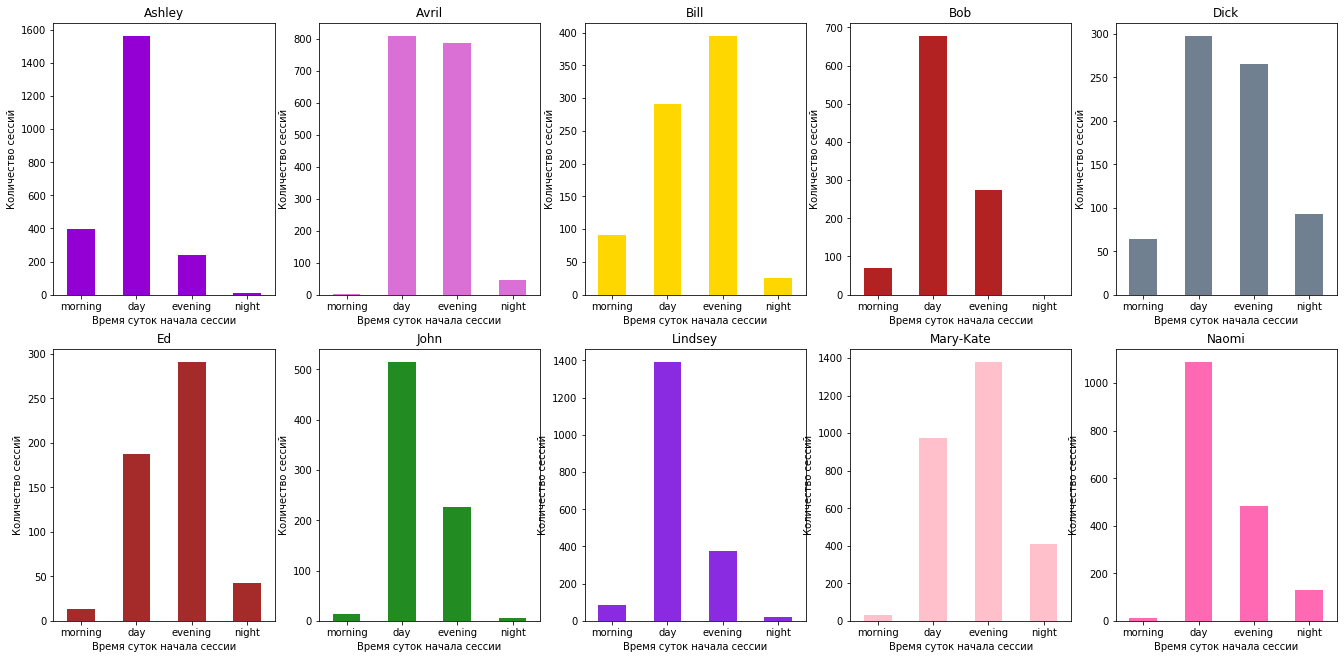

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(23, 11))

for idx, ((user, sub_df), ax) in enumerate(zip(new_10users.groupby('target')['time_of_day'],
                                               axes.flatten())):
    value_counts = sub_df.value_counts().sort_index()
    value_counts.plot(kind='bar', ax=ax, color=color_dic[user])
    ax.set_title(user)
    ax.set_ylabel('Количество сессий')
    ax.set_xlabel('Время суток начала сессии')
    ax.set_xticklabels(value_counts.index, rotation=0)

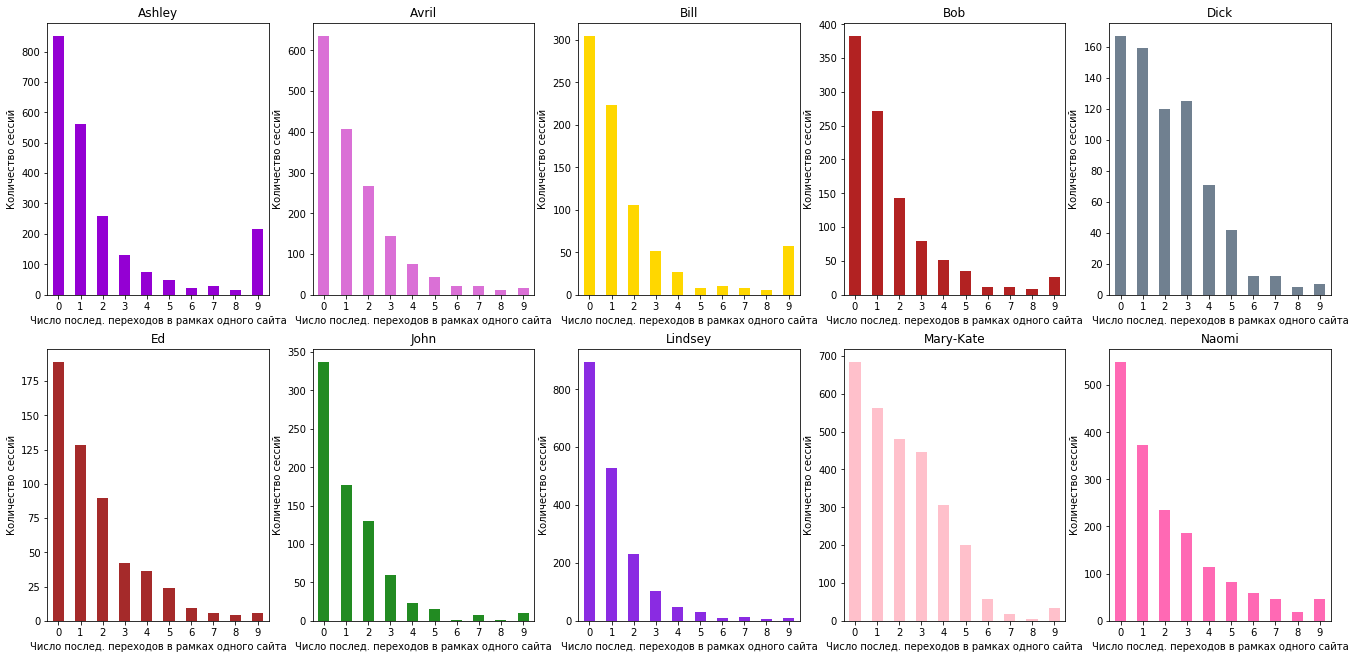

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(23, 11))

for idx, ((user, sub_df), ax) in enumerate(zip(new_10users.groupby('target')['num_consecutive_sites'],
                                               axes.flatten())):
    value_counts = sub_df.value_counts().sort_index()
    value_counts.plot(kind='bar', ax=ax, color=color_dic[user])
    ax.set_title(user)
    ax.set_ylabel('Количество сессий')
    ax.set_xlabel('Число послед. переходов в рамках одного сайта')
    ax.set_xticklabels(value_counts.index, rotation=0)

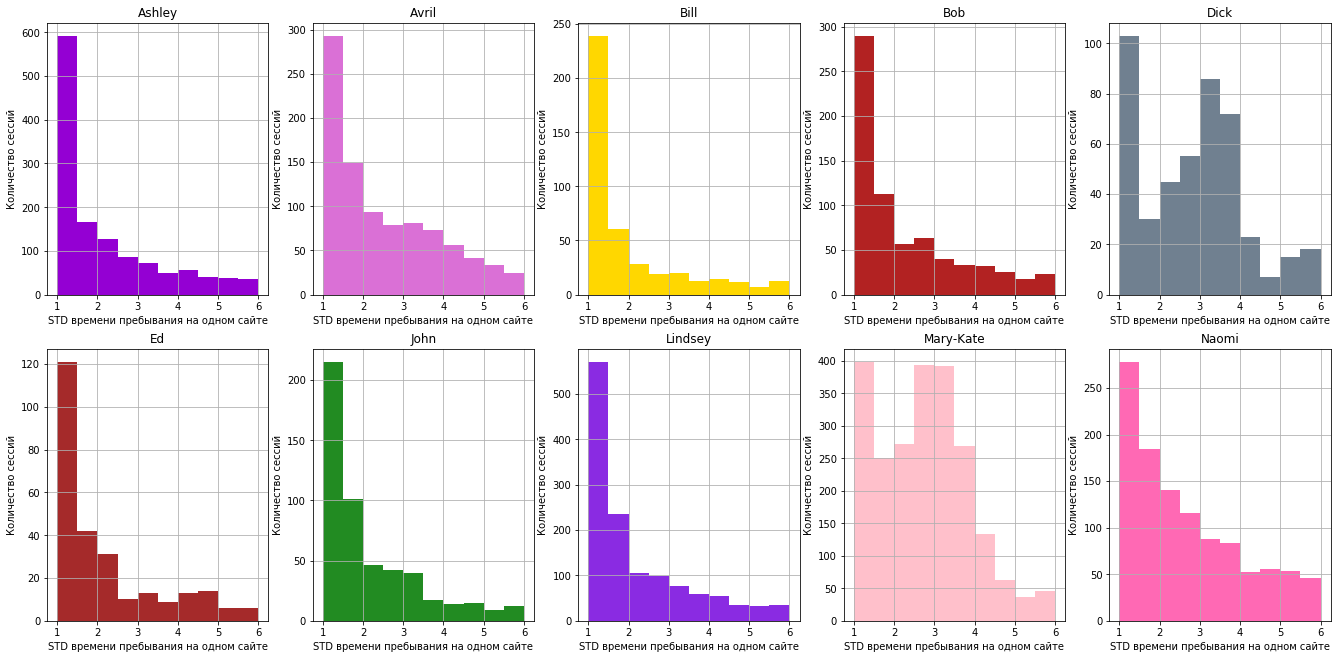

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(23, 11))

for idx, ((user, sub_df), ax) in enumerate(zip(new_10users.groupby('target')['time_diff_std'],
                                               axes.flatten())):
    sub_df.hist(ax=ax, color=color_dic[user], range=(0, 10))
    ax.set_title(user)
    ax.set_ylabel('Количество сессий')
    ax.set_xlabel('STD времени пребывания на одном сайте')
    ax.set_xticklabels(value_counts.index, rotation=0)

In [37]:
new_features_150users = feature_engineering(train_data_150users)
new_150users = pd.concat((train_data_150users, new_features_150users), axis=1)

Ожидаемо, разные пользователи имеют различные характерные времена суток начала сессий.

Также было обнаружено, что некоторые пользователи более склонны переходить по ссылкам в рамках одного сайта (Мэри-Кейт и Дик). Мы можем предположить, что для этих пользователей характерна некоторая консервативность.

Мною был введён признак стандартного отклонения времени пребывания на одном сайте в рамках одной сессии. Те же юзеры (Мэри-Кейт и Дик) показывают отличные от остальных распределения этого параметра: наблюдается бимодальность.

Это может означать либо то, что данные юзеры любят подолгу сидеть на одном сайте, либо это может объясняться тем, что характерная длительность интернет-сёрфинга для них меньше 10 переходов по ссылкам.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [38]:
features = pd.Index(
    ('session_timespan', '#unique_sites', 'start_hour',
     'day_of_week', 'num_consecutive_sites', 'time_of_day', 'time_diff_std')
)

selected_features_10users = new_10users[features]
selected_features_150users = new_150users[features]

In [39]:
with open(os.path.join(PATH_TO_PICKLED, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl)
with open(os.path.join(PATH_TO_PICKLED, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 